# Поиск fraud - отзывов

**Постановка задачи**:
Пользователи загружают изображения в раздел отзывы. Недобросовестные пользователи используют отзывы для рекламы своих товаров или услуг.

Так могут выглядеть допустимые изображений:


<img src ="https://ml.gan4x4.ru/wb/text/content/not_fraud.png" width="800">

Вот примеры недопустимых изображений:

<img src ="https://ml.gan4x4.ru/wb/text/content/fraud.png" width="800">

Как правило такие изображения содержат контактные данные: номера телефонов, ссылку на сайт, телеграмм аккаунт и.т.п.




**Требуется** :

Разработать алгоритм/програмную систему позволяющую отличить допустимые фото от недопустимых. Сложность  обуславливается тем, что допустимые фотографии тоже могут содержать текст.

## Данные

Датасет состоит из ~20000 изображений. Изображения находящиеся в папке “0” - допустимые. В папке “1” - фродовые. Ниже код для его загрузки.



In [ ]:
!wget https://ml.gan4x4.ru/wb/text/75_20000/student.zip
!unzip student.zip
!pip install datasets
!pip install gdown
!pip install timm

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: student/1/149610976.jpg  
  inflating: student/1/129674528.jpg  
  inflating: student/1/125396577.jpg  
  inflating: student/1/127087227.jpg  
  inflating: student/1/159205119.jpg  
  inflating: student/1/154666115.jpg  
  inflating: student/1/154378553.jpg  
  inflating: student/1/124305339.jpg  
  inflating: student/1/156139077.jpg  
  inflating: student/1/155544077.jpg  
  inflating: student/1/156292238.jpg  
  inflating: student/1/156277206.jpg  
  inflating: student/1/130572529.jpg  
  inflating: student/1/153861869.jpg  
  inflating: student/1/132308657.jpg  
  inflating: student/1/158124677.jpg  
  inflating: student/1/156426357.jpg  
  inflating: student/1/126276651.jpg  
  inflating: student/1/156551001.jpg  
  inflating: student/1/169304078.jpg  
  inflating: student/1/158198307.jpg  
  inflating: student/1/142220244.jpg  
  inflating: student/1/167952643.jpg  
  inflating: student/1/128490041.jp

# Решение

In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from datasets import load_dataset
from sklearn.metrics import roc_auc_score
from ipywidgets import FloatProgress
from tqdm import tqdm
from tqdm.notebook import tqdm
import string
from collections import Counter
from typing import List
from nltk.tokenize import sent_tokenize, word_tokenize
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
import json
import re
import nltk
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
import gdown
from torchvision import transforms
from torchvision.datasets import ImageFolder
import timm
from torch import optim
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

from google.colab import drive
drive.mount('/content/drive')

nltk.download('punkt')

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# EDA

In [ ]:
images0 = os.listdir("/content/student/0")
images1 = os.listdir("/content/student/1")
print(len(images0))
print(len(images1))

15000
4808


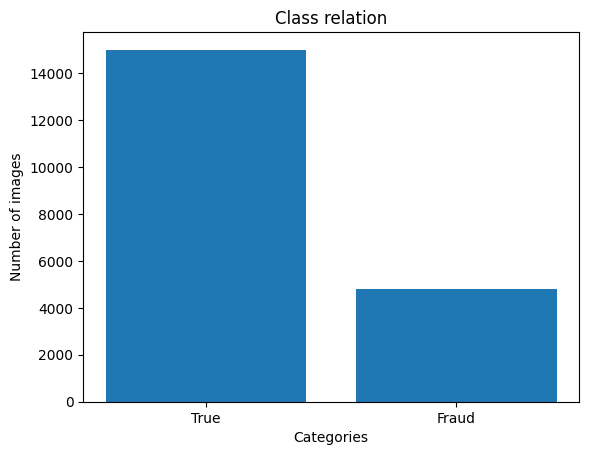

In [ ]:
categories = ['True', 'Fraud']
values = [len(images0), len(images1)]

plt.bar(categories, values)

plt.xlabel("Categories")
plt.ylabel("Number of images")
plt.title("Class relation")

plt.show()
# сгенерировать картинки с текстом + обучать один слой

#Baseline

## Cкачивание датасета

In [ ]:
file_url = 'https://drive.google.com/uc?id=1ZBBoz95SzdwX0Tmoo-OE6I8hq90IFbKK'
output = 'data_texts.csv'

gdown.download(file_url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ZBBoz95SzdwX0Tmoo-OE6I8hq90IFbKK
To: /content/data_texts.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 151MB/s]


'data_texts.csv'

## ViT

In [ ]:
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageFolder('/content/student', transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# randomsampler для батчей

In [ ]:
model = timm.create_model('vit_base_patch16_384', pretrained=True)
num_classes = 2
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion.to(device)

CrossEntropyLoss()

In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = train_loss / total_train
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_loss / total_val
    val_accuracy = correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/1:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 1/1, Train Loss: 0.1733, Train Accuracy: 0.9489, Val Loss: 0.1274, Val Accuracy: 0.9647


In [ ]:
model.eval()

true_labels = []
pred_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        probs = torch.softmax(outputs, dim=1)[:, 1]

        true_labels.extend(labels.cpu().numpy())
        pred_probs.extend(probs.cpu().numpy())

true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)

pred_labels = (pred_probs >= 0.5).astype(int)

roc_auc = roc_auc_score(true_labels, pred_probs)
f1 = f1_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)


print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

  0%|          | 0/124 [00:00<?, ?it/s]

ROC-AUC: 0.9792
F1 Score: 0.9253
Precision: 0.9373
Recall: 0.9136


In [ ]:
model_save_path = "/content/drive/MyDrive/ViT_weights.pth"
torch.save(model.state_dict(), model_save_path)

## Вывод

Трансформер достаточно хорошо справился с задачей, захватив 89% данных и верно классифицировав 97% из них.

# Блок для проверки

In [ ]:
!pip install datasets
!pip install gdown
!pip install timm

unzip:  cannot find or open student.zip, student.zip.zip or student.zip.ZIP.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [ ]:
import os
import torch
from PIL import Image
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from datasets import load_dataset
from ipywidgets import FloatProgress
from tqdm import tqdm
from tqdm.notebook import tqdm
import string
from collections import Counter
from typing import List
from nltk.tokenize import sent_tokenize, word_tokenize
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
import json
import re
import nltk
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.model_selection import train_test_split
import gdown
from torchvision import transforms
from torchvision.datasets import ImageFolder
import timm
from torch import optim
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
nltk.download('punkt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'cuda'

In [ ]:
url = 'https://drive.google.com/file/d/1TuO72czvfPWReVmHbcqxWwXCoGu_ax9T'
output = '/content/best_ViT_weights.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/file/d/1TuO72czvfPWReVmHbcqxWwXCoGu_ax9T
To: /content/best_ViT_weights.pth
87.2kB [00:00, 1.80MB/s]


'/content/best_ViT_weights.pth'

In [ ]:
path_to_test = "/your/path/here/please"

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageFolder(path_to_test, transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = timm.create_model('vit_base_patch16_384', pretrained=True)
num_classes = 2
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)
torch.save(model.state_dict(), output)
model.load_state_dict(torch.load('/content/best_ViT_weights.pth'))

model.eval()

true_labels = []
pred_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        true_labels.extend(labels.cpu().numpy())
        pred_probs.extend(probs.cpu().numpy())

true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)
pred_labels = (pred_probs >= 0.5).astype(int)

roc_auc = roc_auc_score(true_labels, pred_probs)
f1 = f1_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)


print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

ROC-AUC: 0.5000
F1 Score: 0.6667
Precision: 0.6667
Recall: 0.6667
